In [1]:
import warnings

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, csc_matrix
from scipy.sparse.linalg import norm

from sklearn.linear_model import ElasticNet
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split


from polara.datasets.movielens import get_movielens_data

from SLIM import SLIM, SLIMatrix

from dataprep import split_holdout, sample_unseen_interactions

warnings.filterwarnings("ignore")

In [2]:
#Check data for consistency

def check_train_test(train, test, itemid='itemid'):
    intersection = np.setdiff1d(test[itemid], train[itemid]).tolist()
    print(intersection)
    if len(intersection) == 0:
        return
    train = train.append(test.query(f"{itemid:s} == @intersection"))
    test = test.query(f"{itemid:s} != @intersection")
    return train, test

In [3]:
#Make P matrix that our final recommendation model

def rec_walk_model(W, R, alp=0.005):
    normW = norm(W, np.inf) # Count infinite matrix norm of our Model
    ones = np.ones(W.shape[0])
    W = W / normW
    diagVec = ones - W.dot(ones)
    row = range(0,diagVec.shape[0])
    col = range(0,diagVec.shape[0])
    Diag = csr_matrix((diagVec, (row, col)), shape=(diagVec.shape[0], diagVec.shape[0]))
    W = W + Diag

    M = csr_matrix(np.diag(np.ones(R.shape[0] + R.shape[1])), dtype='float64') # One of two Mtx in RecWalkModel
    M[M.shape[0]-W.shape[0]:, M.shape[0]-W.shape[0]:] = W

    H = csr_matrix(np.diag(np.zeros(R.shape[0] + R.shape[1])), dtype='float64')
    H[: R.shape[0], H.shape[1] - R.shape[1]:] = R
    H[H.shape[0] - R.shape[1]:, : R.shape[0]] = R.transpose()
    k = H.dot(np.ones(R.shape[0] + R.shape[1]))
    k = 1 / k
    H = csr_matrix((H.transpose().dot(np.diag(k).transpose())).transpose())

    P = alp*H + (1 - alp)*M
    return P

### HR & ARHR function is the same as in PureSVD

In [4]:
def HR(rec_mtx, holdout_unseen, holdout, userid='userid', itemid='itemid', arhr=False, topN = 10):
    summ_hr = 0.0
    summ_arhr = 0.0
    for i in holdout[userid].values:
        holdout_unseen[i] = np.append(holdout_unseen[i], holdout[itemid][i])
        sor = (rec_mtx.loc[i:i][holdout_unseen[i]]
                .unstack()
                .sort_values(ascending=False)[:topN]
                .droplevel(level=1, axis=0)
                .index
        )
        if holdout[itemid][i] in sor:
            summ_hr = summ_hr + 1
            if arhr:
                local = sor.to_series(index=range(1,topN+1))[sor==holdout[itemid][i]].index[0]
                summ_arhr = summ_arhr + 1/local    
   
    return summ_hr/holdout.shape[0], summ_arhr/holdout.shape[0]    

In [5]:
# randomization control
seed = 0
holdout_seed = 42 # to sample unseen items for holdout
# evaluation setitings
target_metric = 'hr'

In [6]:
full_data = pd.read_csv('/home/albert/Recommendations/yahoo_data_full.gz')
full_data.head(5)

,userid,itemid,is_holdout
0,346,1,False
1,385,1,False
2,517,1,False
3,538,1,False
4,651,1,False


In [7]:
rs = np.random.RandomState(seed)

train, holdout = split_holdout(  # test
    full_data,
    sample_max_rated = True,
    feedback = 'is_holdout',
    random_state = rs
)
holdout.index = holdout.userid

In [8]:
assert not train.is_holdout.any()
assert holdout.is_holdout.all()

In [9]:
holdout_unseen = sample_unseen_interactions(
    full_data,
    train.itemid.unique(), 
    seed=holdout_seed)
holdout_unseen.head()

userid
346    [146, 895, 303, 1293, 624, 1287, 623, 436, 327...
385    [2180, 1352, 502, 2802, 978, 2530, 3149, 999, ...
517    [946, 416, 3254, 2866, 3030, 3256, 1902, 2226,...
538    [1305, 2289, 1916, 2807, 2576, 2778, 1977, 753...
651    [8, 2669, 2827, 2558, 3114, 2320, 428, 1155, 1...
Name: itemid, dtype: object

In [10]:
train.is_holdout = 1.0
ratingMtx = train.pivot(index='userid', columns='itemid', values='is_holdout').fillna(0.0)
ratingMtx.head()

itemid,1,2,3,4,5,6,7,8,9,10,...,3303,3304,3305,3306,3307,3308,3309,3310,3311,3312
userid,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
ratingMtx.shape

(7307, 3312)

In [12]:
sparseRating = csr_matrix(ratingMtx.to_numpy())

In [13]:
#What is the density of initial rating?:

a = ratingMtx.index.size
b = ratingMtx.columns.size
c = a * b

print("Users: {};\nItems: {};\nEntries all: {};\nEntries non zero: {};\nDensity of A: {};\n".\
      format(a, b, c, sparseRating.size, sparseRating.size / c))

Users: 7307;
Items: 3312;
Entries all: 24200784;
Entries non zero: 397438;
Density of A: 0.016422525815692583;



In [14]:
#Parameters on NN:

num = 0.1
C = int(ratingMtx.columns.size*num)
initHR = 0.0

In [15]:
 #Train Matrix W:
trainmat = SLIMatrix(sparseRating)
params = {'algo':'cd',
          'nthreads':4,
          'l1r':10,
          'l2r':10,
          'nnbrs': C
         }
model = SLIM()
model.train(params, trainmat)
    
#Got Matrix W:
WSlim = model.to_csr()

Learning takes 3.560 secs.


In [16]:
#Density of distance matrix W, diagonal and other elements
print("Density of Rating matrix: {};\n".format(sparseRating.size / c))
print("Density of W: {};\n".format(WSlim.size / WSlim.shape[0]**2))
print("Number of elements less than 0 in W matrix: {} \n".format(WSlim.toarray()[WSlim.toarray()<0].size))
print("Maximal diagonal element of the W matrix: {}\n".format(WSlim.diagonal().max()))

Density of Rating matrix: 0.016422525815692583;

Density of W: 0.004607203493663796;

Number of elements less than 0 in W matrix: 0 

Maximal diagonal element of the W matrix: 0.0



In [17]:
#RecWalk P matrix with W SLIM based:
PMtxSlim = rec_walk_model(WSlim, sparseRating).toarray()

In [19]:
#Make a few more steps to future to capture intersactions between items:
K = 20
kMtxSlim = PMtxSlim
hr_arhr = []
for k in range(K): 
    kMtxSlim = kMtxSlim@PMtxSlim
        
    #Get essential information on scores from achieved Recommendation Matrix P:
    RecSlim = pd.DataFrame(kMtxSlim[: ratingMtx.shape[0], ratingMtx.shape[0]:], 
                                   index=ratingMtx.index,
                                   columns=ratingMtx.columns,
                                   dtype='float64')
        
    #Count HR/ARHR of Recommendation for every user using test set:
    hr_arhr.append(HR(RecSlim, holdout_unseen, holdout, arhr=True))               

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [29]:
hr = []
arhr= []
for i in hr_arhr:
    hr.append(i[0])
    arhr.append(i[1])

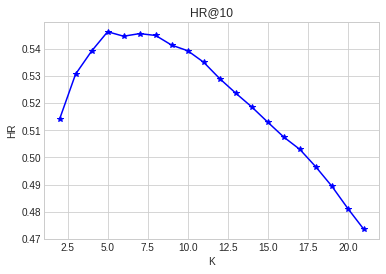

In [42]:
x = range(2,22)
plt.title(f"HR@10")
plt.xlabel("K")
plt.ylabel("HR");
plt.plot(x, hr, '*-b')

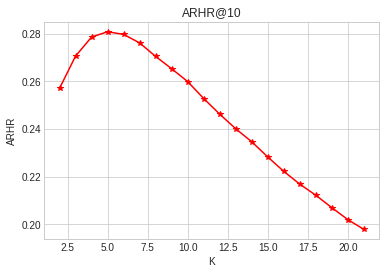

In [43]:
plt.title(f"ARHR@10")
plt.xlabel("K")
plt.ylabel("ARHR");
plt.plot(x, arhr, '*-r')

In [44]:
hr_arhr[3]# k = 5 -> 3 elem.

(0.546188586287122, 0.28086836714522384)

### Best result: HR@10 =0.5461; 
#### k = 5; y1 = 10; y2 = 10; C = 331; alp = 0.005;

### Best result: ARHR@10 = 0.2808; 
#### k = 5; y1 = 10; y2 = 10; C = 331; alp = 0.005;

In [46]:
np.savez_compressed('W_model_SLIM.npz', WSlim = WSlim)